# Profile processing Step 3b: Looking at profile data 

There are two ways to look at and process the master dataset created in step 2, i.e. the file ```0_analysis_output/particle_profile_data.csv```. The first is to do it by groups identified in step 1 (what is done in the step 2a notebook) The second is to group the data by specified depth bins or particle number bins (what is done in this Step 3b notebook).

To look at the data, three types of input are needed. The first is just the path to the cast of interest. The second type of user input pertains to values needed to convert the particle data from pixel-based measurements to micron-based measurements and the development of particle size distribution statistics. The third is the bin spacing in the vertical and the location of the bottom of the first bin off or at the bed. The default value for the bin spacing is 1-meter bins (reported at the bin's vertical midpoint) with a bottom value of 0 (i.e., the first bin goes from the top of the bed to 1 m off the bed and is reported at 0.5 m off the bed). However, this can be adjusted as desired.

Several types of files will be generated when running the cells of this notebook. The data types include:
- Summary statistics for each point in the profile ("Data_0_ProupSummary.csv")
- Plot of the profile (ProcData_3_figure-profile.pdf)

The last cell allows for comparison between grouped and profile data

In [11]:
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display 
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
%matplotlib widget

In [12]:
""" --- User input ----------------------------- """

# folder/file paths
lisstbins_file = '../LISST_bins/LISST_bins_random_ext.csv' # LISST bin data if used

# user-set parameters for processing the data
muperpix = 0.925 # muperpix is the number of microns per per pixel (1.28 is equal to 800 pix per mm)
darea = 1 # use 1 to base particle size on area, 0 to base it on the minor axis of the fit elips
useLISST = 1  # use 1 if list bins sizes are to be used
vdist = 1 # use particle vol for distributions rather than the frequency weighting... if 1, then the w value below does not matter, if 0, w value is used
nb = 30
w = 3 # the distribution weighting value 0 = by number, 1 = by diameter (Ali's), 2 = by area, 3 = by vol

# inputs needed for mass concentration proxy
nf = 2.5 # floc fractal dimension
dp = 8   # primary particle size in micron
Rs = 1.5 # submerged specific gravity of solid primary particles
image_vol = 10**-4 #(in liters)

"""  ------------------------------------------- """

# files to use... should not need to change
castpath = pd.read_csv('0_CastPath.csv').profile_path[0]+'/'
pdata_file = '0_analysis_output/particle_profile_data.csv' #dataframe with all of the particle data
breakpoint_file = 'Data-Breakpionts.csv'
depth_file = 'Depth.csv'

# read in the file
pdata = pd.read_csv(castpath+pdata_file)       
totaldepth = pd.read_csv(castpath+depth_file)['Depth [m]'][0]

# take a look at the break points

if(os.path.exists(castpath+breakpoint_file) == True):
    breakpoints = pd.read_csv(castpath+breakpoint_file)
    print("Here are the breakpoints in the profile.")
    display(breakpoints)
else:
    print('No breakpoint file found, will process all data as a single profile')

Here are the breakpoints in the profile.


,Type/Location,Start [DateTime],End [DateTime],Durration [sec]
0,surface,1.092021e+12,1.092021e+12,60
1,d1,1.092021e+12,1.092021e+12,138
2,d2,1.092021e+12,1.092021e+12,51
3,d3,1.092021e+12,1.092021e+12,53
4,d4,1.092021e+12,1.092021e+12,56
5,d5,1.092021e+12,1.092021e+12,21
6,d6,1.092021e+12,1.092021e+12,62
7,bottom,1.092021e+12,1.092021e+12,26
8,profile,1.092021e+12,1.092021e+12,146


# Define the profile

In [3]:
""" --- User input ----------------------------- """
useall = 'yes' # set to "yes" to use all the data in a profile, set to "no" to use a specific break, then set k in the next line
k = 8 # enter the index associated with profile. If no breakpoints exist the value does not matter

## Extract the profile data and save

In [4]:
if(os.path.exists(castpath+breakpoint_file) == True and useall == 'no'):

    pdata_profile = pdata[(pdata['Image Time'] >= breakpoints['Start [DateTime]'][k]) &
             (pdata['Image Time'] <= breakpoints['End [DateTime]'][k])].copy()
    
else:
    pdata_profile = pdata.copy()
    
pdata_profile=pdata_profile.drop(columns=['MeanGreyValue', 'StdDev', 'MinGreyValue', 'BX', 'BY',
                                             'Width','Height'])
    
# set particle size and put in micron
if(darea == 1):
    d = np.sqrt(4*(np.array(pdata_profile.Area)*muperpix**2)/np.pi)
else:
    d = np.array(pdata_profile.Minor)

pdata_profile['D [mu]'] = d

print('Profile data -----------')
print('- Local depth [m] =', np.around(totaldepth,decimals=2))
print('- Distance off bed range z [m] =',np.around(np.min(pdata_profile['z [m]']),decimals=2), ' to ',
     np.around(np.max(pdata_profile['z [m]']),decimals=2))

if(os.path.exists(castpath+breakpoint_file) == True and useall == 'no'):
    pdata_profile.to_csv(castpath+'ProcData_1_timeseries-'+breakpoints['Type/Location'][k]+'.csv',index=False)
    print('- durration [sec]:',breakpoints['Durration [sec]'][k])
else: 
    pdata_profile.to_csv(castpath+'ProcData_1_timeseries-all'+'.csv',index=False)

print('- number of unique images:', len(pdata_profile['ImgNo'].unique())) 
print('- number of particles:', len(pdata_profile['Number']))
display(pdata_profile)

Profile data -----------
- Local depth [m] = 15.49
- Distance off bed range z [m] = 0.02  to  15.06
- number of unique images: 770
- number of particles: 55298


,Number,ImgNo,NoInTot,Area,MaxGreyValue,Perimeter,Major,Minor,Angle,Circularity,...,Round,Solidity,Streak_impact,Image Time,z [m],Depth [m],T [Celsius],SpC [MicroSiemens/cm],PSU,D [mu]
0,2,1,2,57,103,31.556,11.238,6.458,162.655,0.719,...,0.575,0.814,0,1.092021e+12,14.949069,0.542709,8.483363,267.401792,0.192222,7.880145
1,6,1,6,48,100,39.799,16.109,3.794,175.163,0.381,...,0.236,0.706,0,1.092021e+12,14.949069,0.542709,8.483363,267.401792,0.192222,7.231317
2,9,1,9,173,111,57.355,20.752,10.614,147.353,0.661,...,0.511,0.799,0,1.092021e+12,14.949069,0.542709,8.483363,267.401792,0.192222,13.728397
3,12,1,12,269,153,81.740,28.407,12.057,122.434,0.506,...,0.424,0.765,0,1.092021e+12,14.949069,0.542709,8.483363,267.401792,0.192222,17.118785
4,13,1,13,48,116,36.385,14.439,4.233,166.026,0.456,...,0.293,0.727,0,1.092021e+12,14.949069,0.542709,8.483363,267.401792,0.192222,7.231317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55293,357,970,399594,170,122,51.355,17.201,12.584,15.995,0.810,...,0.732,0.867,0,1.092021e+12,14.932008,0.559769,8.458081,273.814987,0.192231,13.608845
55294,364,970,399601,4923,106,337.019,105.264,59.547,173.677,0.545,...,0.566,0.876,0,1.092021e+12,14.932008,0.559769,8.458081,273.814987,0.192231,73.233824
55295,366,970,399603,1121,117,184.551,39.986,35.695,67.448,0.414,...,0.893,0.738,0,1.092021e+12,14.932008,0.559769,8.458081,273.814987,0.192231,34.946171
55296,371,970,399608,300,132,67.355,22.167,17.232,2.466,0.831,...,0.777,0.910,0,1.092021e+12,14.932008,0.559769,8.458081,273.814987,0.192231,18.078293


## Process using fixed bin sizes

,z [m],PSU,Temp [C],Num. Images,Total Vol [muL],Num. Particles,C proxy [mg/L],D16 [mu],D50 [mu],D84 [mu],D95 [mu]
0,0.75,0.193020,8.359309,33.0,0.553551,4890.0,244.468548,56.876795,91.978624,145.248091,219.983130
1,1.50,0.192971,8.360987,24.0,0.298633,2692.0,180.478652,57.179106,93.955890,160.769276,275.533795
2,2.25,0.192570,8.368321,93.0,0.877343,7972.0,136.521528,57.773252,95.433934,161.869822,252.875213
3,3.00,0.192460,8.370719,92.0,0.808289,7862.0,127.315050,57.291369,94.667180,159.650231,253.303750
4,3.75,0.192475,8.372592,24.0,0.202714,2654.0,122.422290,55.243032,95.063691,170.351552,287.071606
5,4.50,0.192391,8.376172,35.0,0.247004,4235.0,103.370324,50.320590,87.630911,188.385976,279.440438
6,5.25,0.192364,8.380710,109.0,0.770312,9185.0,101.309848,57.909963,105.080166,208.004694,259.615637
7,6.00,0.192355,8.382232,93.0,0.665019,6613.0,101.767994,61.597333,110.951207,211.903239,262.998892
8,6.75,0.192344,8.376585,23.0,0.113915,1472.0,73.569490,51.388336,84.661459,122.218865,174.912832
9,7.50,0.192310,8.378903,26.0,0.135610,2019.0,76.797792,50.633473,85.381654,155.596500,246.758352


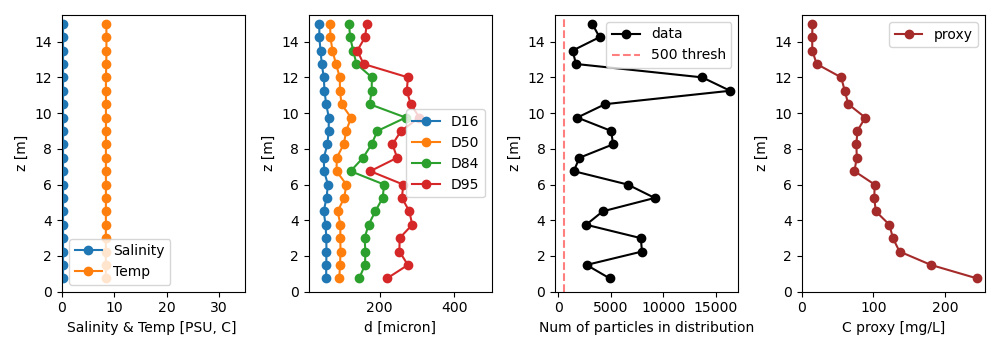

In [14]:
""" --- User input ----------------------------- """
# spatial bin setup. Enter the start and total bin height
pstart = 0
pbinsize = 1.5
"""  ------------------------------------------- """

# calculate the bin centers and top and bottom of bin (sliding window)
halfstep = pbinsize/2

bin_edges=np.arange(pstart, totaldepth+halfstep, halfstep)
bin_centers = bin_edges[1:-1]
N = len(bin_centers)
bin_B = np.zeros(N)
bin_T = np.zeros(N)
for i in range(1,N+1):
    bin_B[i-1]=bin_edges[i-1]
    bin_T[i-1]=bin_edges[i+1]
    # print('bin:',i,bin_edges[i-1],bin_edges[i+1])

# pd.DataFrame({'centers':bin_centers,'lower edge':bin_B,'upper edge':bin_T})

# setup summary arrays

salinity = np.zeros(N)
temp = np.zeros(N)
numpart = np.zeros(N)
numimg = np.zeros(N)
d16 = np.zeros(N)
d50 = np.zeros(N)
d84 = np.zeros(N)
d95 = np.zeros(N)
d95 = np.zeros(N)
Vtotal = np.zeros(N)
Solidity = np.zeros(N)
Mass_per_image = np.zeros(N)

for j in range(0,N):

    pdata_group = pdata_profile[(pdata_profile['z [m]'] >= bin_B[j]) & (pdata_profile['z [m]'] <= bin_T[j])].copy()
    
    # pdata_group.to_csv(castpath+'ProcData_1_timeseries-'+summary['Type/Location'][j]+'.csv',index=False)

    d = np.array(pdata_group['D [mu]'])
    
    salinity[j] = np.mean(pdata_group['PSU'])
    temp[j] = np.mean(pdata_group['T [Celsius]'])
    Solidity[j]= np.mean(pdata_group['Solidity'])
    
    numimg[j] = int(len(pdata_group['ImgNo'].unique()))
    dvol_uL = 1e-9*(np.pi/6)*d**3 # volume of each particle in microliters (1 micron^3 = 1e-9 microliters)
    Rf = Rs*(d/dp)**(nf-3) # submerged specific gravity of the flocs
    mass_mg = dvol_uL*(Rf+1) # mass (in mg) of each floc
    Mass_per_image[j] = np.sum(mass_mg)/numimg[j] # floc mass per image (averaged over the group)
    
    numpart[j]=int(len(d))

    if useLISST == 1:
        lisst_bins = pd.read_csv(lisstbins_file)
        edges = list(lisst_bins.Lower)
        edges.append(lisst_bins.Upper.iloc[-1])

    dlog=np.log(d)

    if vdist == 1:
        if useLISST == 1:
            values, base = np.histogram(d, bins=edges, weights=dvol_uL)
            centers = np.array(lisst_bins.Median)
            width = base[1:]-base[:-1]
        else:
            values, logbase = np.histogram(dlog, bins=nb, weights=dvol_uL)
            logcenters = (logbase[1:]+logbase[:-1])/2
            base = np.exp(logbase)
            width = base[1:]-base[:-1]
            centers = np.exp(logcenters)
        Vtotal[j]=sum(values)
    else:
        if useLISST == 1:
            values, base = np.histogram(d, bins=edges)
            centers = np.array(lisst_bins.Median)
            width = base[1:]-base[:-1]
            values=values*(centers)**w
        else:
            values, logbase = np.histogram(dlog, bins=nb)
            logcenters = (logbase[1:]+logbase[:-1])/2
            base = np.exp(logbase)
            width = base[1:]-base[:-1]
            centers = np.exp(logcenters)
            values=values*(centers)**w
    
    # pdf=pd.DataFrame({'d_mu':centers,'vol_or_freq':values})
    # pdf.to_csv(castpath+'ProcData_2_PDF-'+summary['Type/Location'][j]+'.csv',index=False)
    
    cumulative = np.cumsum(values) # adds up the frequencies (total is the total number of points)
    
    if np.sum(values) == 0:
        d16[j]=np.nan
        d50[j]=np.nan
        d84[j]=np.nan
        d95[j]=np.nan  
    else:
        valuefrac = values/np.sum(values)
        perc = cumulative/cumulative[len(cumulative)-1]
        percfiner = perc
        percfiner = np.insert(percfiner,0,0)

        d16[j]=np.interp(0.16,percfiner,base)
        d50[j]=np.interp(0.5,percfiner,base)
        d84[j]=np.interp(0.84,percfiner,base)
        d95[j]=np.interp(0.95,percfiner,base)

    # cdf=pd.DataFrame({'d_mu':base,'fracfiner':percfiner})
    # cdf.to_csv(castpath+'ProcData_2_CDF-'+summary['Type/Location'][j]+'.csv',index=False)

summary = pd.DataFrame({'z [m]':bin_centers,'PSU':salinity,'Temp [C]':temp,'Num. Images':numimg,'Total Vol [muL]':Vtotal,'Num. Particles':numpart,'C proxy [mg/L]':Mass_per_image/image_vol,'D16 [mu]':d16, 'D50 [mu]':d50,'D84 [mu]':d84, 'D95 [mu]':d95})

summary.to_csv(castpath+'ProcData_0_ProfileSummary.csv',index=False)
display(summary)

# plot the data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(10,3.5))
ax1.plot(summary['PSU'], summary['z [m]'], '-o', alpha=1,label='Salinity')
ax1.plot(summary['Temp [C]'], summary['z [m]'], '-o', alpha=1,label='Temp')
ax1.set_xlim(0,35)
ax1.set_ylim(0,totaldepth)
ax1.set_ylabel('z [m]')
ax1.set_xlabel('Salinity & Temp [PSU, C] ')
ax1.legend(loc=3)
ax2.plot(summary['D16 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D16')
ax2.plot(summary['D50 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D50')
ax2.plot(summary['D84 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D84')
ax2.plot(summary['D95 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D95')
ax2.set_xlim(10,500)
ax2.set_ylim(0,totaldepth)
ax2.set_ylabel('z [m]')
ax2.set_xlabel('d [micron]')
ax2.legend()

ax3.plot(summary['Num. Particles'], summary['z [m]'], '-o',color='k',alpha=1,label='data')
ax3.set_ylim(0,totaldepth)
ax3.set_ylabel('z [m]')
ax3.set_xlabel('Num of particles in distribution')
ax3.axvline(x = 500, color = 'r', linestyle = '--', alpha=0.5, label='500 thresh')
ax3.legend()
# ax3.axhline(y = totaldepth, color = 'b', linestyle = '--', label='water surface')

ax4.plot(summary['C proxy [mg/L]'], summary['z [m]'], '-o',color='brown',alpha=1,label='proxy')
# ax4.axvline(x = 500, color = 'r', linestyle = '--', alpha=0.5, label='500 thresh')
ax4.set_ylim(0,totaldepth)
ax4.set_xlim(0,)
ax4.set_ylabel('z [m]')
ax4.set_xlabel('C proxy [mg/L]')
ax4.legend()

fig.tight_layout();
plt.savefig(castpath+'ProcData_3_figure-profile.pdf',bbox_inches="tight", pad_inches=0.005)

## Compare with grouped data [if you have it]

,Type/Location,Start [DateTime],End [DateTime],Durration [sec],Depth [m],z [m],PSU,Temp [C],Num. Images,Num. Particles,D16 [mu],D50 [mu],D84 [mu],D95 [mu],Total Vol [muL],C proxy [mg/L],Solidity_avg
0,surface,1.092021e+12,1.092021e+12,60,0.764552,14.727225,0.192684,8.474724,56.0,2094.0,38.945370,67.559280,118.254897,175.061002,0.053805,14.777240,0.835231
1,d1,1.092021e+12,1.092021e+12,138,3.699369,11.792408,0.192235,8.381052,140.0,10773.0,51.535226,96.292923,193.482464,295.872159,0.578238,60.079362,0.817197
2,d2,1.092021e+12,1.092021e+12,51,4.335105,11.156672,0.192257,8.388982,59.0,3187.0,54.078881,88.352688,145.462395,246.240900,0.227317,56.530708,0.835423
3,d3,1.092021e+12,1.092021e+12,53,6.691787,8.799991,0.192329,8.387105,62.0,3075.0,64.251336,109.129949,177.554089,227.313012,0.326572,75.219211,0.832827
4,d4,1.092021e+12,1.092021e+12,56,9.681741,5.810036,0.192351,8.384619,67.0,4114.0,65.184077,117.375088,213.810990,260.274018,0.461008,97.292120,0.826382
5,d5,1.092021e+12,1.092021e+12,21,10.365421,5.126356,0.192365,8.377623,19.0,2317.0,44.796367,75.721145,113.663269,151.069483,0.112175,89.499168,0.819558
6,d6,1.092021e+12,1.092021e+12,62,12.554197,2.937580,0.192383,8.371325,76.0,5742.0,58.218085,96.300404,159.821860,380.121895,0.652028,123.968696,0.824316
7,bottom,1.092021e+12,1.092021e+12,26,15.378757,0.113020,0.193032,8.359074,21.0,3658.0,55.487870,89.617940,135.028526,169.648696,0.380584,265.992996,0.810914


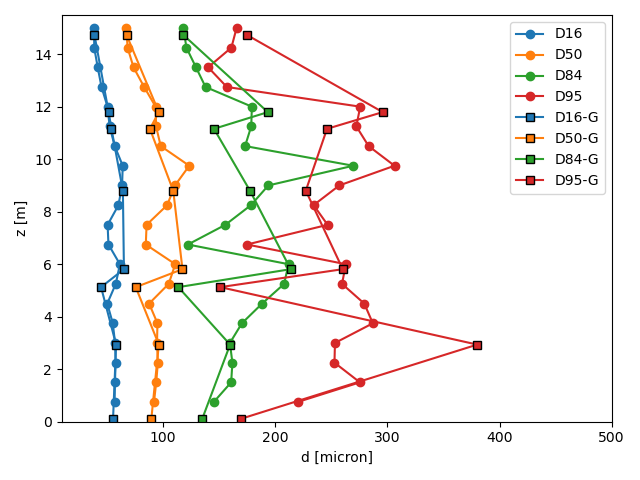

In [15]:
grouped = pd.read_csv(castpath+'ProcData_0_GroupSummary.csv')
display(grouped)

# plot the data
fig, (ax1) = plt.subplots(1,1)
ax1.plot(summary['D16 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D16')
ax1.plot(summary['D50 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D50')
ax1.plot(summary['D84 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D84')
ax1.plot(summary['D95 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D95')

ax1.plot(grouped['D16 [mu]'], grouped['z [m]'], marker='s',color='C00', alpha=1,mec ='k',label='D16-G')
ax1.plot(grouped['D50 [mu]'], grouped['z [m]'], marker='s',color='C01',alpha=1,mec ='k',label='D50-G')
ax1.plot(grouped['D84 [mu]'], grouped['z [m]'], marker='s',color='C02',alpha=1,mec ='k',label='D84-G')
ax1.plot(grouped['D95 [mu]'], grouped['z [m]'], marker='s',color='C03',alpha=1,mec ='k',label='D95-G')

ax1.set_xlim(10,500)
ax1.set_ylim(0,totaldepth)
ax1.set_ylabel('z [m]')
ax1.set_xlabel('d [micron]')
ax1.legend()

fig.tight_layout();